this notebook analysies data MS Dial files with a peak being defined as

"found in 100 % of samples within a sample group"

normalized and raw data.

The conclusion of this analysis is that theres is only a handful of non-significantly different features.

In [1]:
import os, pandas, numpy, qnorm

In [2]:
import scipy, scipy.signal, scipy.stats
import sklearn, sklearn.preprocessing, sklearn.decomposition

In [3]:
import seaborn

In [4]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16, 9), 
                            'axes.labelsize':20
                           })

# 0. user-defined variables

In [5]:
raw_input_file = '/home/adrian/projects/vigur/data/lipidomics/lipidomics_2023.05.26b/Area_8_2023526741.txt'
metadata_file = '/home/adrian/projects/vigur/data/lipidomics/lipidomics_2023.05.26b/EC-008 Sample ID dataframe_16032022.xlsx'

# 1. read information

## 1.1. read data

In [6]:
intensities = pandas.read_csv(raw_input_file, sep='\t', skiprows=4)

# 1.2. read metadata

In [7]:
df = pandas.read_csv(raw_input_file, sep='\t', skiprows=2, nrows=9)
df = df.transpose()
df = df.iloc[32:, :2]
df.rename(columns={0: 'Batch', 1: 'sampleID'}, inplace=True)
df.head()

,Batch,sampleID
1,1,Solvent Blank_lipids_pos BLANK
2,1,Pool2_lipids_pos Pool
3,1,Solvent Blank_lipids_pos BLANK
4,1,008-20 4
5,1,008-11 24


In [8]:
# needed for biological replicate
metadata = pandas.read_excel(metadata_file, sheet_name='Sampledata_POS_Combine')
metadata.head()

,Sample,Label,Sample ID,BioReplicate,Timepoint,µM catech,TecRep,TNFalpha,LPS,cell number,LCMS Method,LCMS Analytical Order,LCMS BATCH
0,PMUEC_INTRA_EC008_103,Pool1_pos,Pool1_pos,-,-,-,-,-,-,-,HILIC_POS_10min,1,1
1,PMUEC_INTRA_EC008_104,Pool1_pos,Pool1_pos,-,-,-,-,-,-,-,HILIC_POS_10min,2,1
2,PMUEC_INTRA_EC008_105,Pool1_pos,Pool1_pos,-,-,-,-,-,-,-,HILIC_POS_10min,3,1
3,PMUEC_INTRA_EC008_107,Pool2_pos,Pool2_pos,-,-,-,-,-,-,-,HILIC_POS_10min,4,1
4,PMUEC_INTRA_EC008_109,008-02_pos,008-2,1,0,0,2,0,0,80000,HILIC_POS_10min,5,1


# 2. process data

In [9]:
# select the samples we need only
selected_columns = []; pools = []

for columnID in intensities.columns:
    if '008' in columnID:
        selected_columns.append(columnID)
    if 'lipids' in columnID and 'Pool.' in columnID:
        selected_columns.append(columnID); pools.append(columnID)
    if 'Pool2_pos' in columnID and 'Pool.' in columnID:
        selected_columns.append(columnID); pools.append(columnID)

selected_columns.sort(); pools.sort()
print(len(selected_columns), selected_columns)
print(len(pools), pools)

53 ['008-01 0', '008-02 0', '008-03 0', '008-04 4', '008-05 4', '008-06 4', '008-07 4 CAT', '008-08 4 CAT', '008-09 4 CAT', '008-10 24', '008-11 24', '008-12 24', '008-13 24   CAT', '008-14 24   CAT', '008-15 24   CAT', '008-16 0', '008-17 0', '008-18 0', '008-19 4', '008-20 4', '008-21 4', '008-22 4 CAT', '008-23 4 CAT', '008-24 4 CAT', '008-25 24', '008-26 24', '008-27 24', '008-28 24   CAT', '008-29 24   CAT', '008-30 24   CAT', '008-31 0', '008-32 0', '008-33 0', '008-34 4', '008-35 4', '008-36 4', '008-37 4 CAT', '008-38 4 CAT', '008-39 4 CAT', '008-40 24', '008-41 24', '008-42 24', '008-43 24   CAT', '008-44 24   CAT', '008-45 24   CAT', 'Pool2_lipids_pos Pool.1', 'Pool2_lipids_pos Pool.2', 'Pool2_lipids_pos Pool.3', 'Pool2_lipids_pos Pool.4', 'Pool2_pos Pool.1', 'Pool2_pos Pool.2', 'Pool2_pos Pool.3', 'Pool2_pos Pool.4']
8 ['Pool2_lipids_pos Pool.1', 'Pool2_lipids_pos Pool.2', 'Pool2_lipids_pos Pool.3', 'Pool2_lipids_pos Pool.4', 'Pool2_pos Pool.1', 'Pool2_pos Pool.2', 'Pool2_po

In [10]:
selected_columns = ['Average Rt(min)'] + selected_columns
selected_columns = ['Average Mz'] + selected_columns

print(len(selected_columns), selected_columns)

55 ['Average Mz', 'Average Rt(min)', '008-01 0', '008-02 0', '008-03 0', '008-04 4', '008-05 4', '008-06 4', '008-07 4 CAT', '008-08 4 CAT', '008-09 4 CAT', '008-10 24', '008-11 24', '008-12 24', '008-13 24   CAT', '008-14 24   CAT', '008-15 24   CAT', '008-16 0', '008-17 0', '008-18 0', '008-19 4', '008-20 4', '008-21 4', '008-22 4 CAT', '008-23 4 CAT', '008-24 4 CAT', '008-25 24', '008-26 24', '008-27 24', '008-28 24   CAT', '008-29 24   CAT', '008-30 24   CAT', '008-31 0', '008-32 0', '008-33 0', '008-34 4', '008-35 4', '008-36 4', '008-37 4 CAT', '008-38 4 CAT', '008-39 4 CAT', '008-40 24', '008-41 24', '008-42 24', '008-43 24   CAT', '008-44 24   CAT', '008-45 24   CAT', 'Pool2_lipids_pos Pool.1', 'Pool2_lipids_pos Pool.2', 'Pool2_lipids_pos Pool.3', 'Pool2_lipids_pos Pool.4', 'Pool2_pos Pool.1', 'Pool2_pos Pool.2', 'Pool2_pos Pool.3', 'Pool2_pos Pool.4']


In [11]:
intensities = intensities[selected_columns]
print(intensities.shape)
intensities.head()

(295, 55)


,Average Mz,Average Rt(min),008-01 0,008-02 0,008-03 0,008-04 4,008-05 4,008-06 4,008-07 4 CAT,008-08 4 CAT,...,008-44 24 CAT,008-45 24 CAT,Pool2_lipids_pos Pool.1,Pool2_lipids_pos Pool.2,Pool2_lipids_pos Pool.3,Pool2_lipids_pos Pool.4,Pool2_pos Pool.1,Pool2_pos Pool.2,Pool2_pos Pool.3,Pool2_pos Pool.4
0,163.11206,7.633,19551,16006,18917,22063,15714,17322,14936,16595,...,15186,16408,11260,11260,11260,11260,20494,20494,20494,20494
1,171.13664,1.085,31810,9300,14875,5126,57420,8441,10868,16443,...,0,4861,9787,9787,9787,9787,4721,4721,4721,4721
2,172.95811,0.838,0,0,0,0,0,3782,8590,8995,...,0,2143,2755,2755,2755,2755,4582,4582,4582,4582
3,186.06477,14.434,78816,72015,75519,77317,70685,74283,67754,65296,...,56895,58061,71541,71541,71541,71541,56791,56791,56791,56791
4,205.12076,7.633,36473,36422,17447,32821,38610,35591,41665,33152,...,49426,25148,42131,42131,42131,42131,28822,28822,28822,28822


In [12]:
# merge mz and RT as unique identifier
intensities.loc[:, 'unique_ID'] = intensities.loc[:, 'Average Rt(min)'].astype(str) + '_' + intensities.loc[:, 'Average Mz'].astype(str)
intensities.drop(['Average Mz', 'Average Rt(min)'], axis='columns', inplace=True)
intensities.set_index('unique_ID', inplace=True)
intensities.sort_index(inplace=True)

print(intensities.shape)
intensities.head()

(295, 53)


,008-01 0,008-02 0,008-03 0,008-04 4,008-05 4,008-06 4,008-07 4 CAT,008-08 4 CAT,008-09 4 CAT,008-10 24,...,008-44 24 CAT,008-45 24 CAT,Pool2_lipids_pos Pool.1,Pool2_lipids_pos Pool.2,Pool2_lipids_pos Pool.3,Pool2_lipids_pos Pool.4,Pool2_pos Pool.1,Pool2_pos Pool.2,Pool2_pos Pool.3,Pool2_pos Pool.4
unique_ID,,,,,,,,,,,,,,,,,,,,,
0.609_305.16281,67675,12522,44189,3546,60393,5770,4463,17208,0,4025,...,2900,7124,35366,35366,35366,35366,13046,13046,13046,13046
0.611_217.10544,23911,34535,27715,10678,53693,12221,14541,33688,23591,9394,...,13002,17906,28658,28658,28658,28658,29187,29187,29187,29187
0.611_349.19458,58195,9586,30547,0,59282,4177,3676,13607,0,3042,...,2848,7395,28916,28916,28916,28916,7650,7650,7650,7650
0.611_393.20673,0,0,0,0,0,3854,0,12631,0,0,...,2605,6655,27520,27520,27520,27520,5808,5808,5808,5808
0.612_261.13141,47393,19154,45862,5176,48129,6266,5819,18756,9216,4994,...,4392,8033,26559,26559,26559,26559,16141,16141,16141,16141


In [13]:
pool_df = intensities[pools]
pool_df.head()

,Pool2_lipids_pos Pool.1,Pool2_lipids_pos Pool.2,Pool2_lipids_pos Pool.3,Pool2_lipids_pos Pool.4,Pool2_pos Pool.1,Pool2_pos Pool.2,Pool2_pos Pool.3,Pool2_pos Pool.4
unique_ID,,,,,,,,
0.609_305.16281,35366,35366,35366,35366,13046,13046,13046,13046
0.611_217.10544,28658,28658,28658,28658,29187,29187,29187,29187
0.611_349.19458,28916,28916,28916,28916,7650,7650,7650,7650
0.611_393.20673,27520,27520,27520,27520,5808,5808,5808,5808
0.612_261.13141,26559,26559,26559,26559,16141,16141,16141,16141


In [14]:
numpy.max(pool_df.iloc[:, 0] - pool_df.iloc[:, 1])

0

In [15]:
log10_intensities = numpy.log10(intensities + 1)
log10_pools = numpy.log10(pool_df + 1)

In [16]:
print(numpy.max(pool_df.iloc[:, 0] - pool_df.iloc[:, 0]))
print(numpy.max(pool_df.iloc[:, 0] - pool_df.iloc[:, -1]))

0
2886500


# 3. visualize data

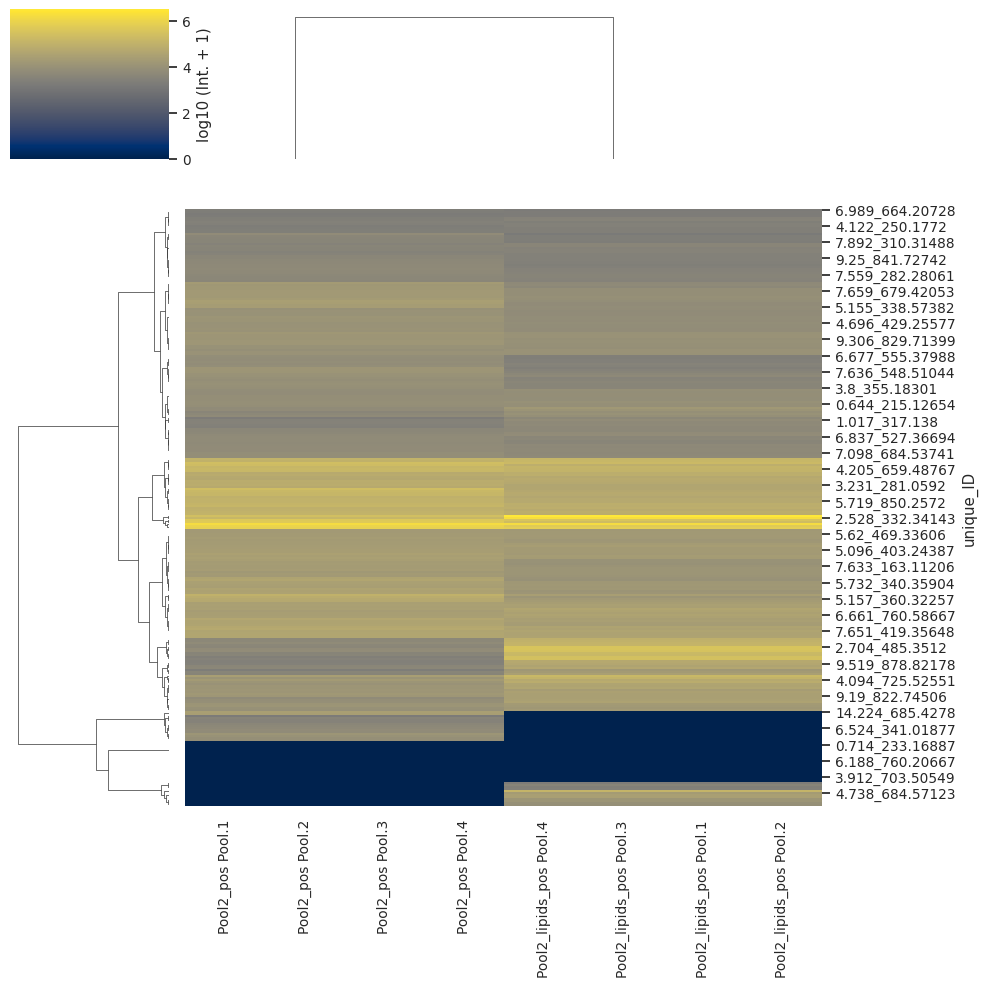

In [17]:
linkage_method = 'ward'
distance_metric = 'euclidean'

seaborn.set(font_scale=0.9)
seaborn.clustermap(log10_pools, 
                   cmap='cividis', 
                   row_cluster=True, col_cluster=True,
                   method=linkage_method, metric=distance_metric, 
                   cbar_kws={'label':'log10 (Int. + 1)'}
                  )
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# 4. quantile normalization

In [18]:
# remove any feature that does not cross the threshold of 300
print(log10_intensities.shape)

log10_intensities = log10_intensities[log10_intensities.max(axis=1) >= numpy.log10(300 + 1)]

print(log10_intensities.shape)
log10_intensities.head()

(295, 53)
(293, 53)


,008-01 0,008-02 0,008-03 0,008-04 4,008-05 4,008-06 4,008-07 4 CAT,008-08 4 CAT,008-09 4 CAT,008-10 24,...,008-44 24 CAT,008-45 24 CAT,Pool2_lipids_pos Pool.1,Pool2_lipids_pos Pool.2,Pool2_lipids_pos Pool.3,Pool2_lipids_pos Pool.4,Pool2_pos Pool.1,Pool2_pos Pool.2,Pool2_pos Pool.3,Pool2_pos Pool.4
unique_ID,,,,,,,,,,,,,,,,,,,,,
0.609_305.16281,4.830435,4.097708,4.645324,3.549861,4.780994,3.761251,3.649724,4.235756,0.000000,3.604874,...,3.462548,3.852785,4.548598,4.548598,4.548598,4.548598,4.115511,4.115511,4.115511,4.115511
0.611_217.10544,4.378616,4.538272,4.442731,4.028531,4.729926,4.087142,4.162624,4.527488,4.372765,3.972897,...,4.114044,4.253023,4.457261,4.457261,4.457261,4.457261,4.465204,4.465204,4.465204,4.465204
0.611_349.19458,4.764893,3.981683,4.484983,0.000000,4.772930,3.620968,3.565494,4.133794,0.000000,3.483302,...,3.454692,3.868997,4.461153,4.461153,4.461153,4.461153,3.883718,3.883718,3.883718,3.883718
0.611_393.20673,0.000000,0.000000,0.000000,0.000000,0.000000,3.586024,0.000000,4.101472,0.000000,0.000000,...,3.415974,3.823213,4.439664,4.439664,4.439664,4.439664,3.764101,3.764101,3.764101,3.764101
0.612_261.13141,4.675723,4.282282,4.661462,3.714078,4.682416,3.797060,3.764923,4.273163,3.964590,3.698535,...,3.642761,3.904932,4.424228,4.424228,4.424228,4.424228,4.207957,4.207957,4.207957,4.207957


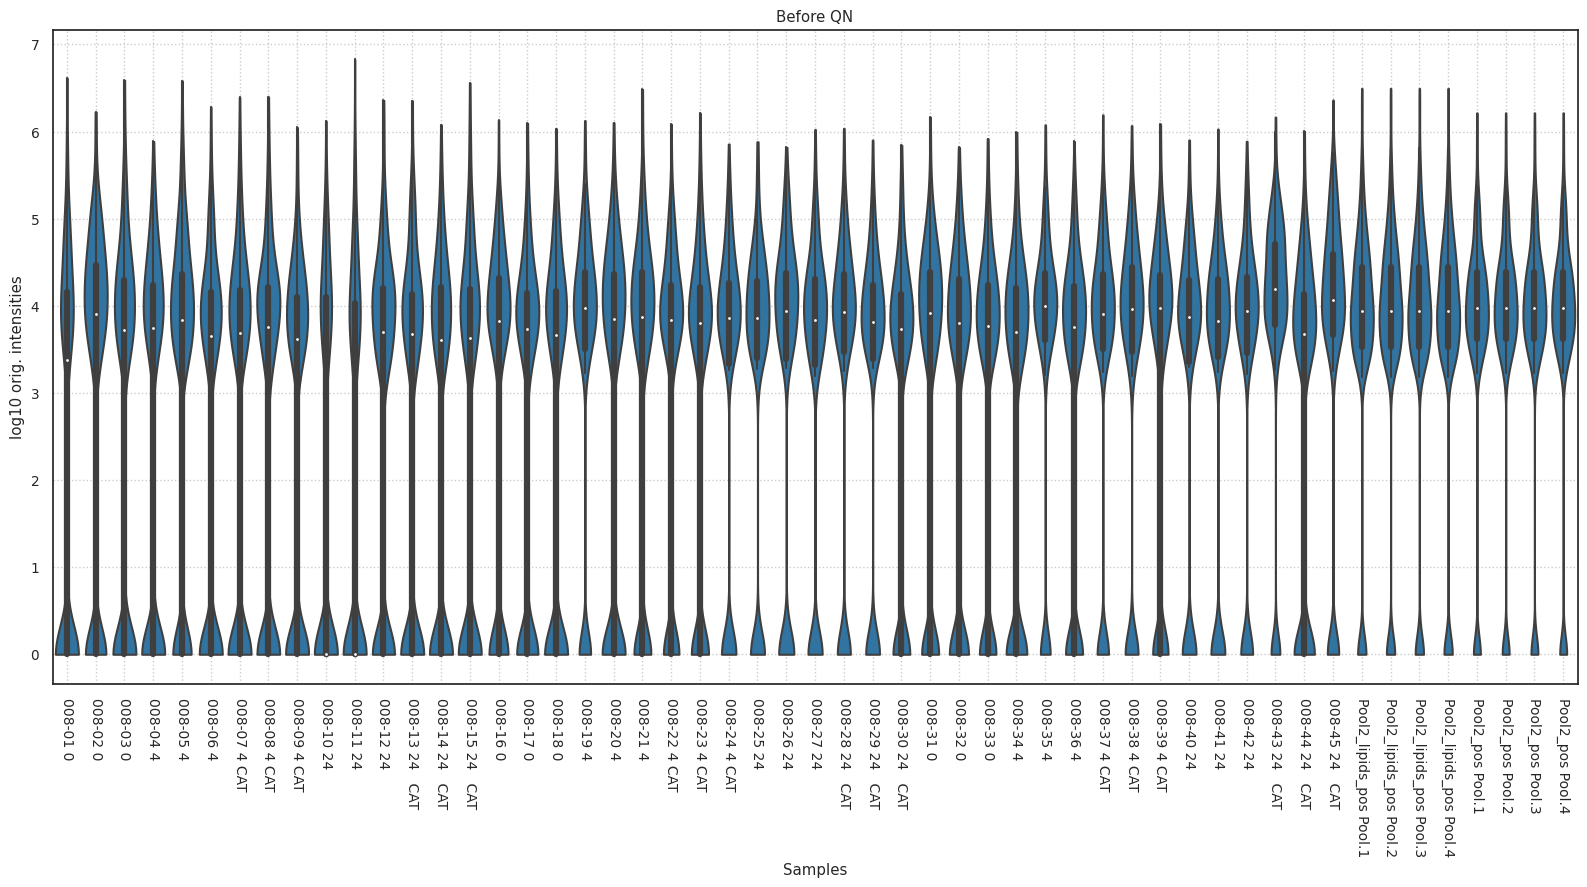

In [19]:
seaborn.set_style("white")
g = seaborn.violinplot(data=log10_intensities, cut=0, bw=.15, scale="count", color='tab:blue')
g.set(ylabel='log10 orig. intensities', xlabel='Samples', title='Before QN')
g.set_xticklabels(g.get_xticklabels(), rotation=-90, fontsize=10)

matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

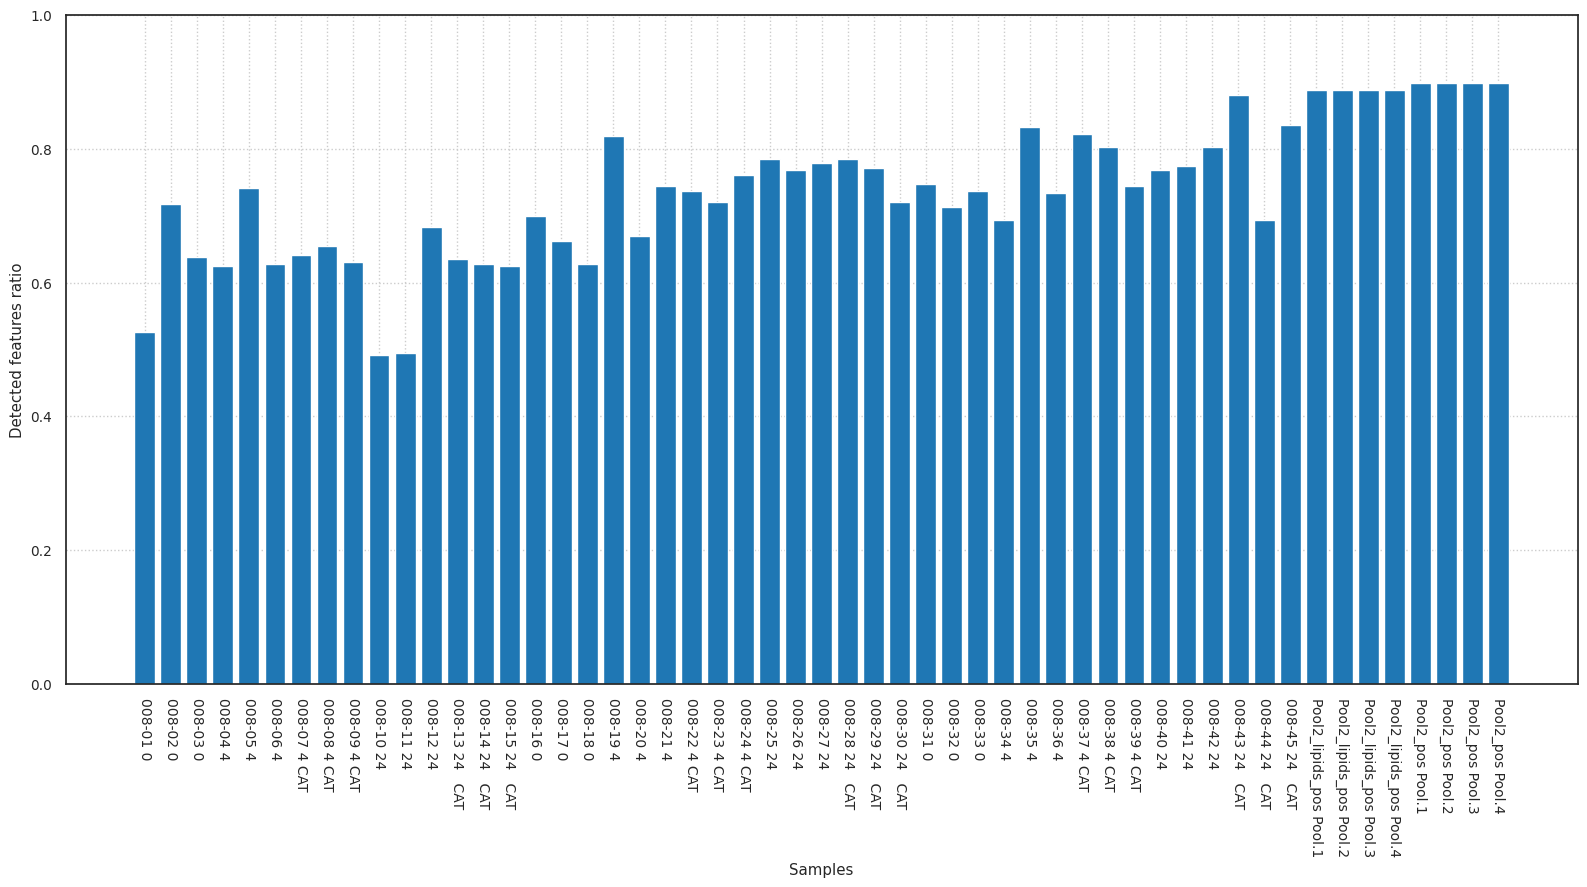

In [20]:
measured = []
for i in range(log10_intensities.shape[1]):
    ratio = sum(log10_intensities.iloc[:, i] > 1) / log10_intensities.shape[0]
    measured.append(ratio)
    
matplotlib.pyplot.bar(range(log10_intensities.shape[1]), measured, color='tab:blue')
matplotlib.pyplot.xticks(range(log10_intensities.shape[1]), log10_intensities.columns, rotation=-90, fontsize=10)
matplotlib.pyplot.xlabel('Samples')
matplotlib.pyplot.ylabel('Detected features ratio')
matplotlib.pyplot.ylim(0, 1)
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [21]:
###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(log10_intensities.values, axis=0), 
                             index=log10_intensities.index, 
                             columns=log10_intensities.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = log10_intensities.rank(method="min").stack().astype(int).map(df_mean).unstack()

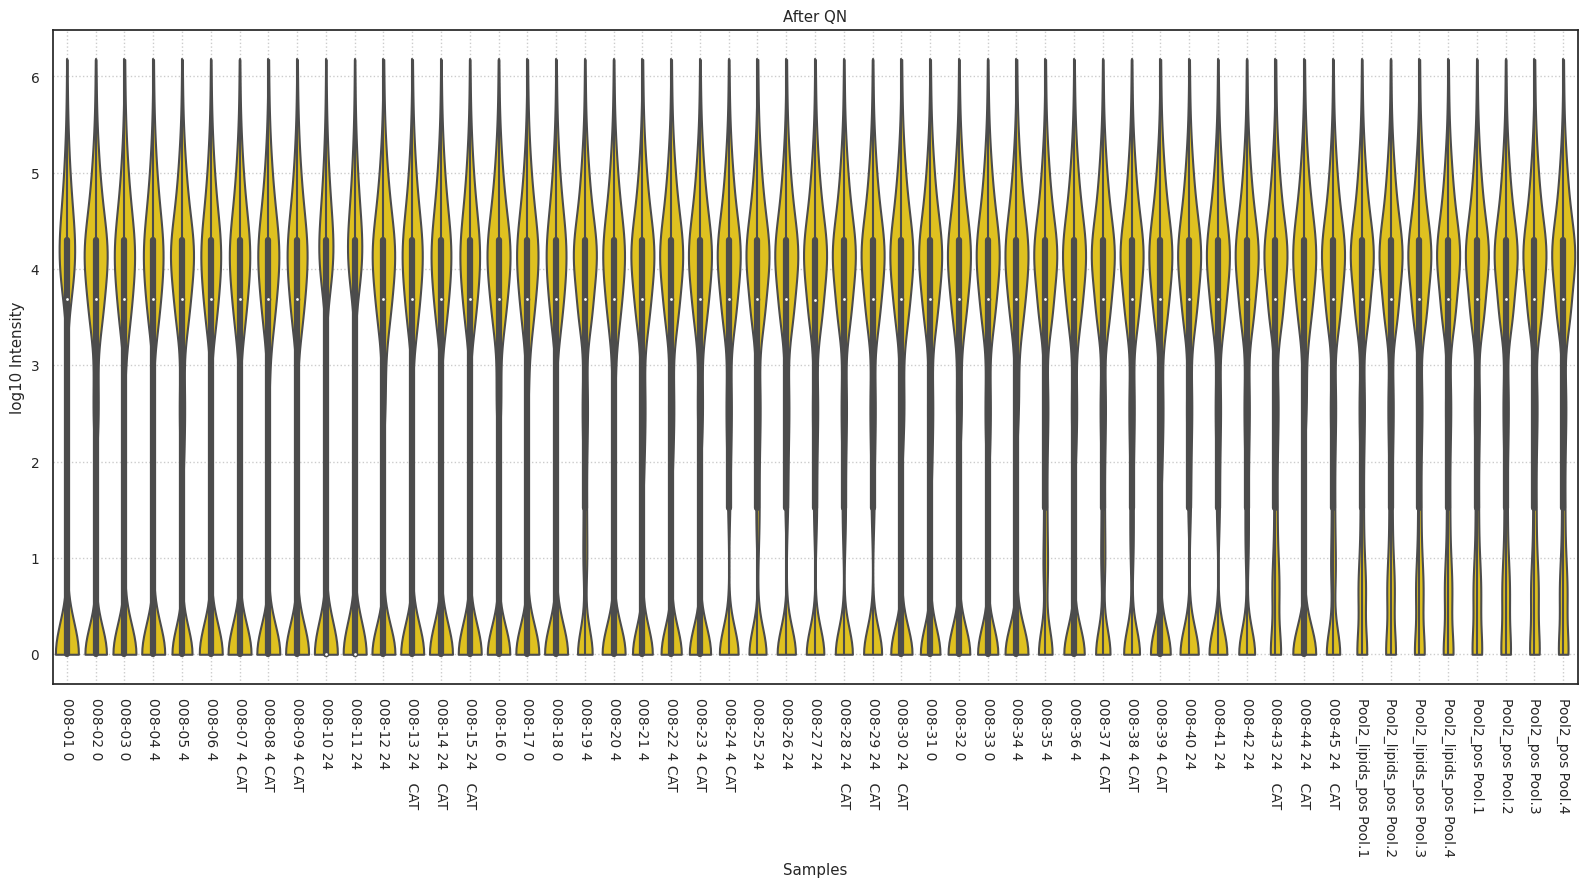

In [22]:
g = seaborn.violinplot(data=df_qn, cut=0, bw=.15, scale="count", color='gold')
g.set(ylabel='log10 Intensity', xlabel='Samples', title='After QN')
g.set_xticklabels(g.get_xticklabels(), rotation=-90, fontsize=10)

matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# 5. add an epsilon to avoid large changes

In [23]:
matplotlib.rc_file_defaults()
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16, 9), 
                            'axes.labelsize':20
                           })

120


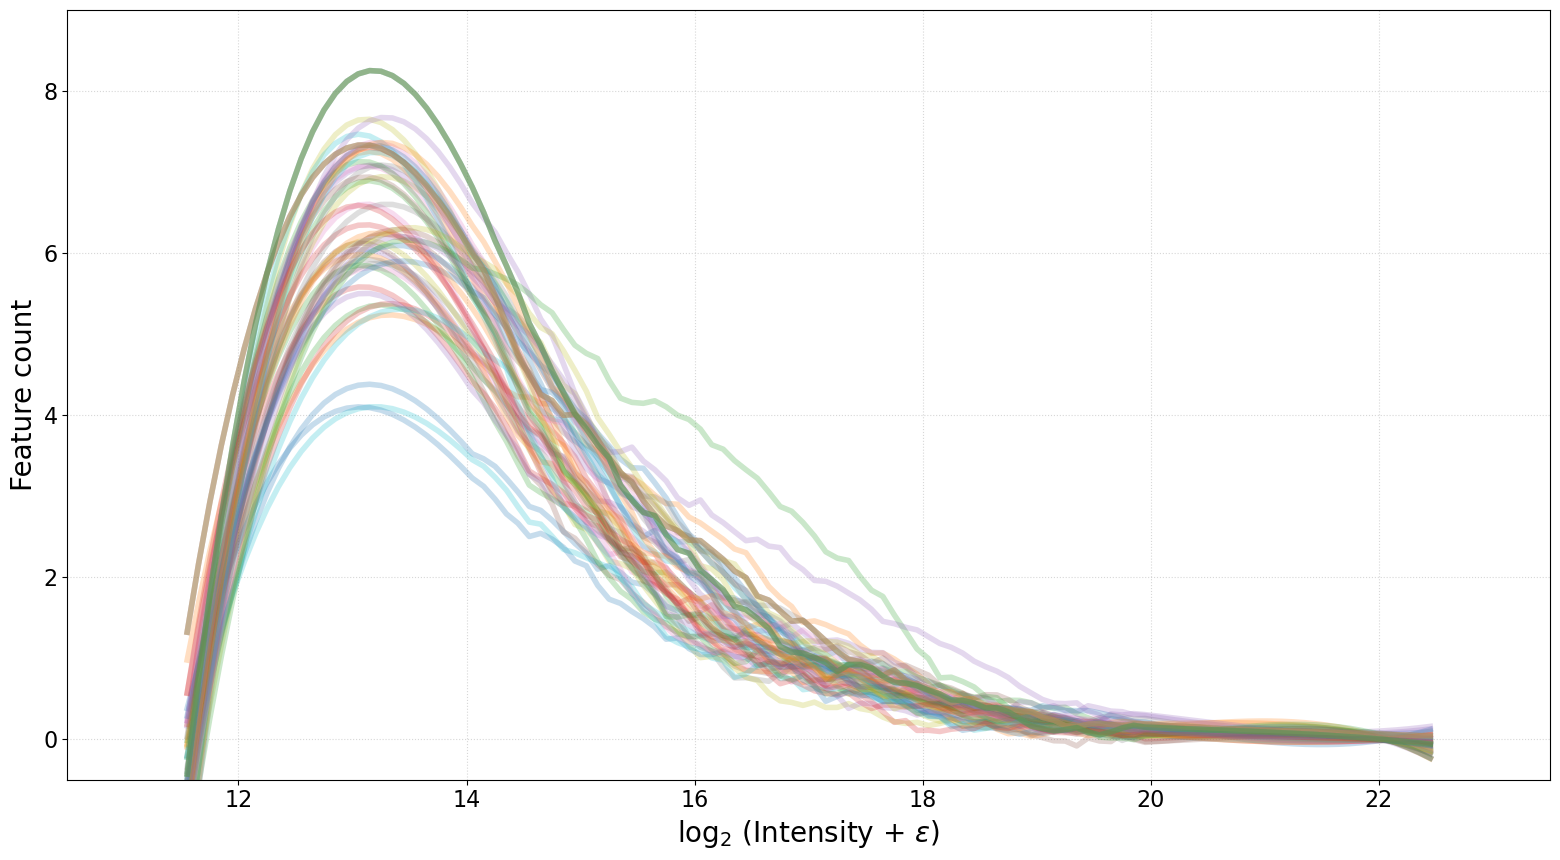

22.679196147502527


In [24]:
epsilon = 11
found_max = 23
number_of_bins = (found_max-epsilon)*10
print(number_of_bins)

absolute_max = 0
ti = numpy.log2(intensities + 2**epsilon)
working_samples = ti.columns.to_list()

for sample in working_samples:
    
    values = ti.loc[:, sample]
    if max(values) > absolute_max:
        absolute_max = max(values)
                
    hist, bin_edges = numpy.histogram(values, bins=number_of_bins, range=(epsilon, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
   
    margin = 5
    plotting_x = x[margin:number_of_bins-margin]
    plotting_hist = hist[margin:number_of_bins-margin]
    
    #matplotlib.pyplot.plot(plotting_x, plotting_hist, '.', alpha=1/3)
    
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/4)
      
matplotlib.pyplot.xlim([10.5, 23.5])
matplotlib.pyplot.ylim([-0.5, 9])

matplotlib.pyplot.xlabel('log$_2$ (Intensity + $\epsilon$)')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':', alpha=0.5)

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

print(absolute_max)

# 6. quantile normalization on log2 Intensities + epsilon

In [25]:
###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(ti.values, axis=0), 
                             index=ti.index, 
                             columns=ti.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = ti.rank(method="min").stack().astype(int).map(df_mean).unstack()

100


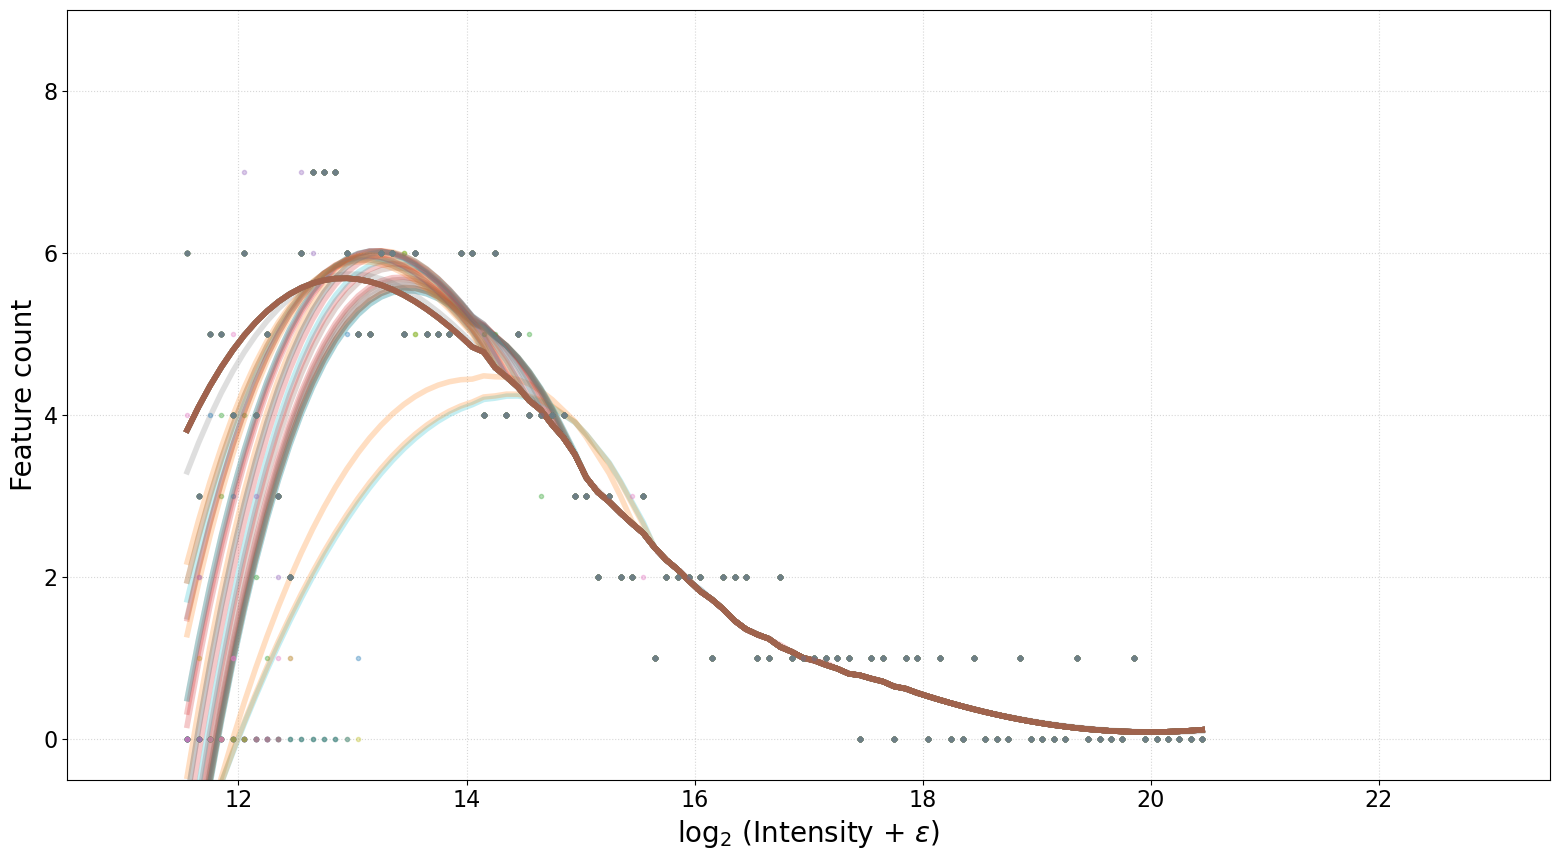

20.517971683211755


In [26]:
epsilon = 11
found_max = 21
number_of_bins = (found_max-epsilon)*10
print(number_of_bins)

absolute_max = 0
working_samples = df_qn.columns.to_list()

for sample in working_samples:
    
    values = df_qn.loc[:, sample]
    if max(values) > absolute_max:
        absolute_max = max(values)
                
    hist, bin_edges = numpy.histogram(values, bins=number_of_bins, range=(epsilon, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
   
    margin = 5
    plotting_x = x[margin:number_of_bins-margin]
    plotting_hist = hist[margin:number_of_bins-margin]
    
    matplotlib.pyplot.plot(plotting_x, plotting_hist, '.', alpha=1/3)
    
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/4)
    
    
matplotlib.pyplot.xlim([10.5, 23.5])
matplotlib.pyplot.ylim([-0.5, 9])

matplotlib.pyplot.xlabel('log$_2$ (Intensity + $\epsilon$)')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':', alpha=0.5)

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

print(absolute_max)

# 7. using a quantile normalization module

In [27]:
df = pandas.DataFrame({'C1': {'A': 5, 'B': 2, 'C': 3, 'D': 4},
                   'C2': {'A': 4, 'B': 1, 'C': 4, 'D': 2},
                   'C3': {'A': 3, 'B': 4, 'C': 6, 'D': 8}})
df.head()

,C1,C2,C3
A,5,4,3
B,2,1,4
C,3,4,6
D,4,2,8


In [28]:
qnorm.quantile_normalize(df, axis=1)

,C1,C2,C3
A,5.666667,5.166667,2.000000
B,2.000000,2.000000,3.000000
C,3.000000,5.166667,4.666667
D,4.666667,3.000000,5.666667


In [29]:
tti = qnorm.quantile_normalize(ti, axis=1)

100
008-01 0 25.758894043022725
008-10 24 28.065448014393535
008-11 24 27.831962586679477


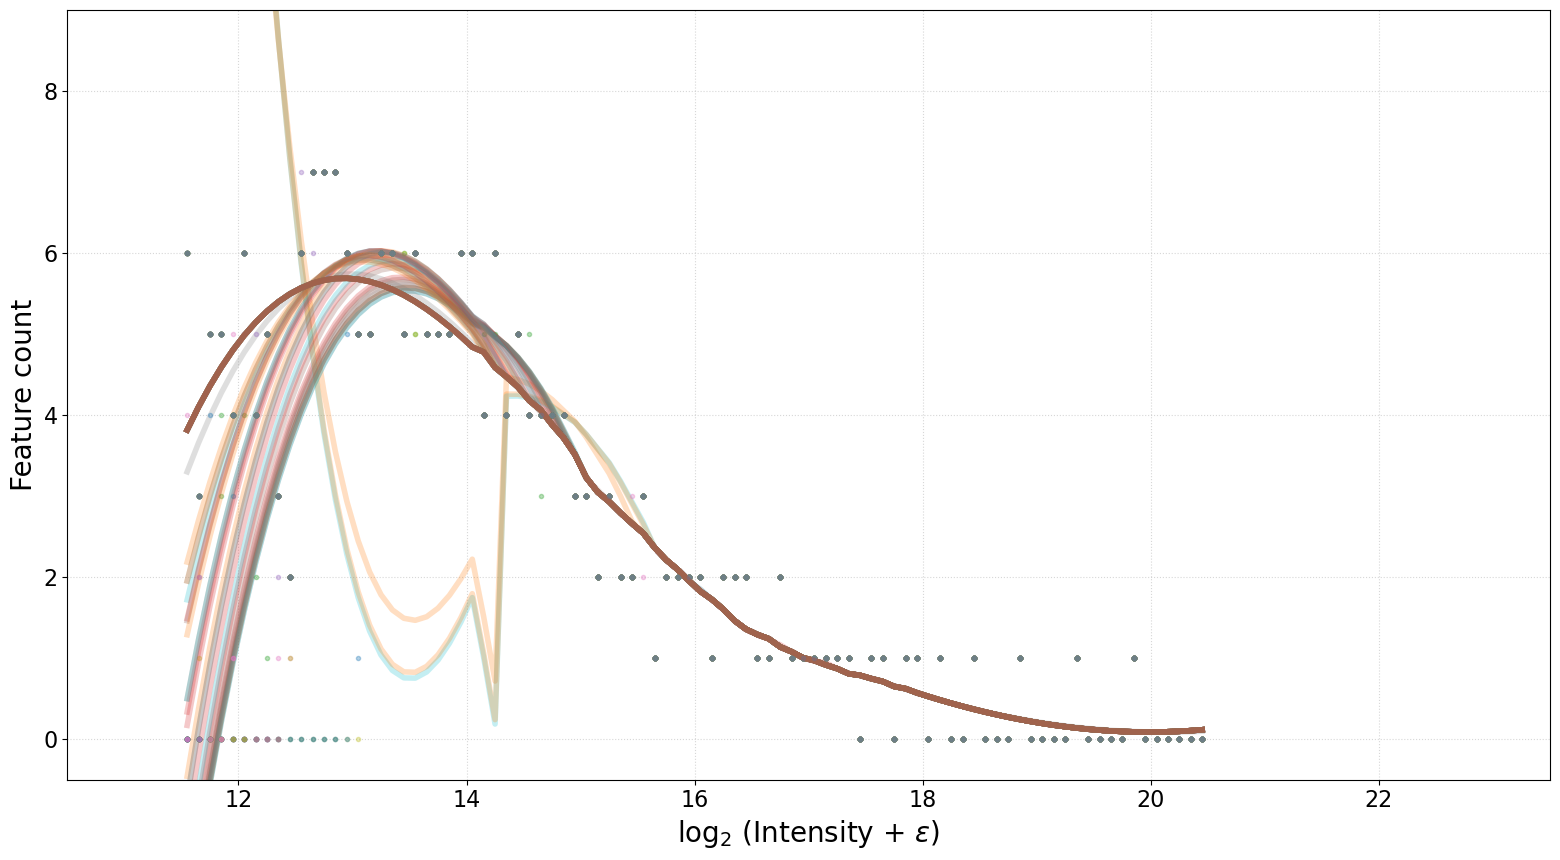

20.517971683211755


In [30]:
failed_samples = []

epsilon = 11
found_max = 21
number_of_bins = (found_max-epsilon)*10
print(number_of_bins)

absolute_max = 0
working_samples = tti.columns.to_list()

for sample in working_samples:
    
    values = tti.loc[:, sample]
    if max(values) > absolute_max:
        absolute_max = max(values)
                
    hist, bin_edges = numpy.histogram(values, bins=number_of_bins, range=(epsilon, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
   
    margin = 5
    plotting_x = x[margin:number_of_bins-margin]
    plotting_hist = hist[margin:number_of_bins-margin]
    
    matplotlib.pyplot.plot(plotting_x, plotting_hist, '.', alpha=1/3)
    
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/4)
    if numpy.max(yhat) > 7:
        print(sample, numpy.max(yhat))
        failed_samples.append(sample.split(' ')[0])
    
matplotlib.pyplot.xlim([10.5, 23.5])
matplotlib.pyplot.ylim([-0.5, 9])

matplotlib.pyplot.xlabel('log$_2$ (Intensity + $\epsilon$)')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':', alpha=0.5)

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

print(absolute_max)

In [31]:
# remove failed samples
print(df_qn.shape)
for failed_sample in failed_samples:
    for columnID in df_qn.columns:
        if failed_sample in columnID:
            df_qn.drop(columnID, axis='columns', inplace=True)
print(df_qn.shape)

(295, 53)
(295, 50)


# 8. identify patterns

variance explained [0.19441971 0.11594023]
(50, 2)
008-02 ['008-01', '008-10', '008-11']
008-03 ['008-01', '008-10', '008-11']
008-04 ['008-01', '008-10', '008-11']
008-05 ['008-01', '008-10', '008-11']
008-06 ['008-01', '008-10', '008-11']
008-07 ['008-01', '008-10', '008-11']
008-08 ['008-01', '008-10', '008-11']
008-09 ['008-01', '008-10', '008-11']
008-12 ['008-01', '008-10', '008-11']
008-13 ['008-01', '008-10', '008-11']
008-14 ['008-01', '008-10', '008-11']
008-15 ['008-01', '008-10', '008-11']
008-16 ['008-01', '008-10', '008-11']
008-17 ['008-01', '008-10', '008-11']
008-18 ['008-01', '008-10', '008-11']
008-19 ['008-01', '008-10', '008-11']
008-20 ['008-01', '008-10', '008-11']
008-21 ['008-01', '008-10', '008-11']
008-22 ['008-01', '008-10', '008-11']
008-23 ['008-01', '008-10', '008-11']
008-24 ['008-01', '008-10', '008-11']
008-25 ['008-01', '008-10', '008-11']
008-26 ['008-01', '008-10', '008-11']
008-27 ['008-01', '008-10', '008-11']
008-28 ['008-01', '008-10', '008-11']

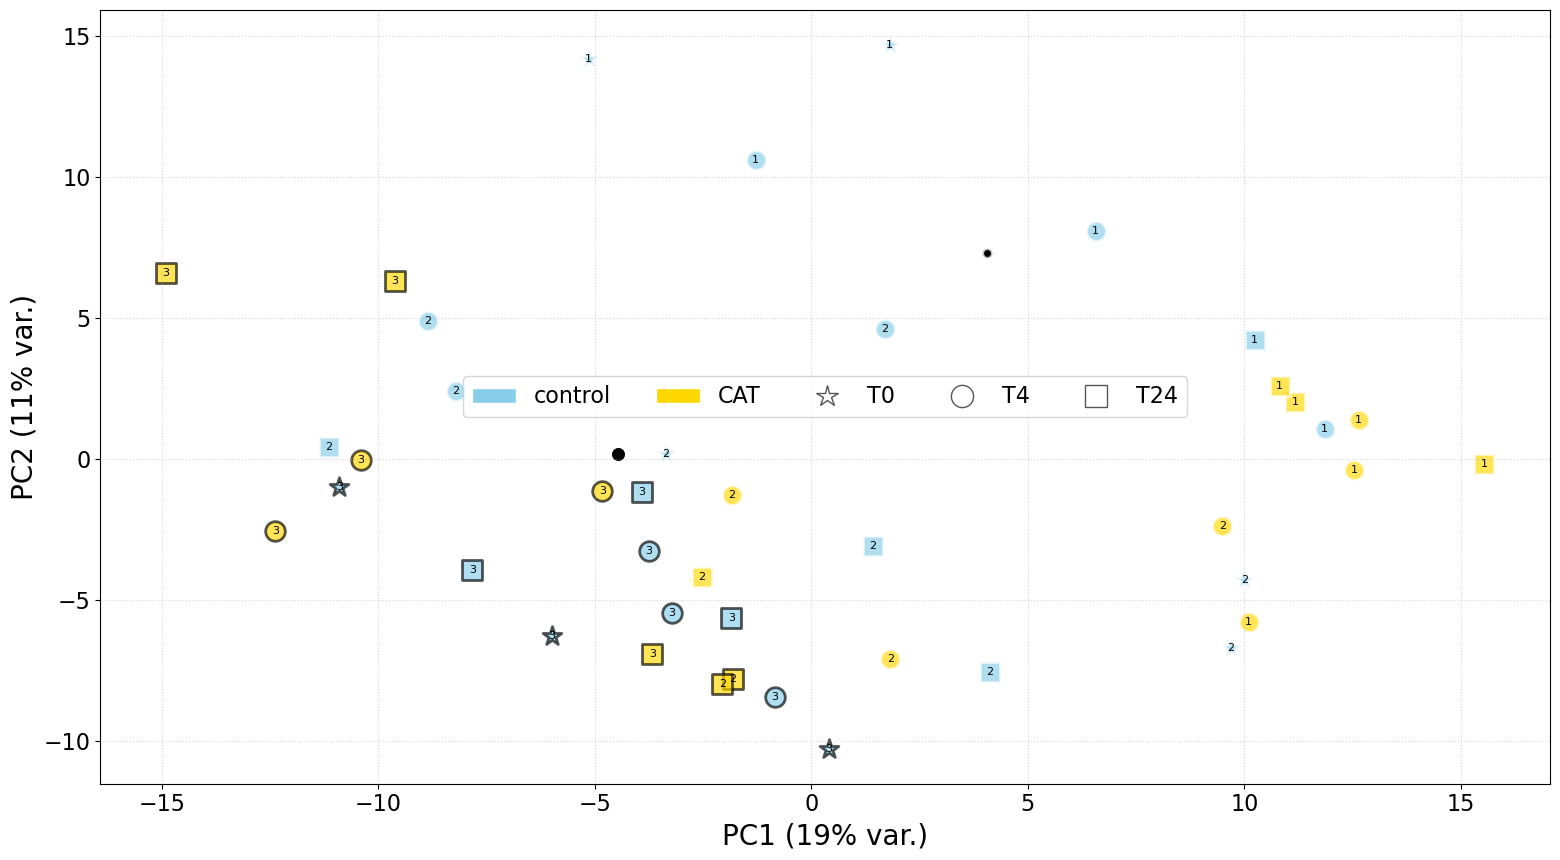

In [32]:
# consider making a PCA of what we have
df = df_qn.transpose()

x = sklearn.preprocessing.StandardScaler().fit_transform(df)
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pandas.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

print('variance explained', pca.explained_variance_ratio_)

print(principal_df.shape)
principal_df.head()

for i in range(len(df.index)):
    
    label = df.index[i].split()
        
    # color for treatment
    if '008' in label[0]:
        if label[-1] == 'CAT':
            plotting_color = 'gold'
        else:
            plotting_color = 'skyblue'
    else:
        plotting_color = 'black'
    
    # marker for time
    if label[1] == '0':
        plotting_marker = '*'
    elif label[1] == '4':
        plotting_marker = 'o'
    elif label[1] == '24':
        plotting_marker = 's'
    else:
        plotting_marker = '.'

    # position
    posx = principal_df.iloc[i]['PC1']
    posy = principal_df.iloc[i]['PC2']
        
    # add biological replicate
    try:
        new_label = label[0].split('-')[0] + '-' + str(int(label[0].split('-')[1]))
        biorep = metadata[metadata['Sample ID'] == new_label]['BioReplicate'].values[0]
        matplotlib.pyplot.text(posx, posy, biorep, fontsize=8, horizontalalignment='center', verticalalignment='center')
    except:
        pass
    
    # add batch
    batch_number = metadata[metadata['Sample ID'] == new_label]['Sample'].values[0].split('_')[-1][0]
    if 'Pool' in label[0]:
        if 'lipids' in label[0]:
            batch_number = '1'
        else:
            batch_number = '2'
        
    if batch_number == '1':
        the_edge_color = 'white'
    elif batch_number == '2':
        the_edge_color = 'black'
    else:
        print('Error finding batch number')

    # plot the dots
    matplotlib.pyplot.scatter(posx, posy, s=200, c=plotting_color, alpha=2/3, ec=the_edge_color, marker=plotting_marker, lw=2)
    print(label[0], failed_samples)
    if label[0] in failed_samples:
        matplotlib.pyplot.scatter(posx, posy, s=200, c='red', alpha=2/3, ec=the_edge_color, marker=plotting_marker, lw=2)
    
# legend
legend_elements = [
    matplotlib.patches.Patch(facecolor='skyblue', edgecolor='white'),
    matplotlib.patches.Patch(facecolor='gold', edgecolor='white'),
    
    matplotlib.lines.Line2D([0], [0], marker='*', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0),
    matplotlib.lines.Line2D([0], [0], marker='o', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0),
    matplotlib.lines.Line2D([0], [0], marker='s', color='black', markerfacecolor='white', markersize=16, alpha=2/3, lw=0)
    ]
matplotlib.pyplot.legend(legend_elements, ['control', 'CAT', 'T0', 'T4', 'T24'], ncol=5, fontsize=16)

# close figure
matplotlib.pyplot.grid(alpha=1/2, ls=':')
matplotlib.pyplot.xlabel('PC1 ({}% var.)'.format(int(pca.explained_variance_ratio_[0]*100)))
matplotlib.pyplot.ylabel('PC2 ({}% var.)'.format(int(pca.explained_variance_ratio_[1]*100)))

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [33]:
df_qn.head()

,008-02 0,008-03 0,008-04 4,008-05 4,008-06 4,008-07 4 CAT,008-08 4 CAT,008-09 4 CAT,008-12 24,008-13 24 CAT,...,008-44 24 CAT,008-45 24 CAT,Pool2_lipids_pos Pool.1,Pool2_lipids_pos Pool.2,Pool2_lipids_pos Pool.3,Pool2_lipids_pos Pool.4,Pool2_pos Pool.1,Pool2_pos Pool.2,Pool2_pos Pool.3,Pool2_pos Pool.4
unique_ID,,,,,,,,,,,,,,,,,,,,,
0.609_305.16281,13.575292,15.378331,12.738544,15.334555,13.340965,12.880265,14.628831,11.000000,13.883599,13.680261,...,12.329065,12.426048,14.753208,14.753208,14.753208,14.753208,13.596957,13.596957,13.596957,13.596957
0.611_217.10544,14.686766,14.965856,13.883599,15.125349,14.224786,14.353012,15.515335,15.334555,14.706955,13.782285,...,14.263645,13.517982,14.447195,14.447195,14.447195,14.447195,14.869908,14.869908,14.869908,14.869908
0.611_349.19458,13.274646,15.051974,11.000000,15.287346,12.995788,12.806909,14.121600,11.000000,13.327077,13.754468,...,12.300259,12.501489,14.469133,14.469133,14.469133,14.469133,12.751380,12.751380,12.751380,12.751380
0.611_393.20673,11.000000,11.000000,11.000000,11.000000,12.906340,11.000000,13.976151,11.000000,11.000000,11.000000,...,12.203963,12.270271,14.423457,14.423457,14.423457,14.423457,12.217475,12.217475,12.217475,12.217475
0.612_261.13141,13.883599,15.546650,12.952779,15.022543,13.435365,13.312595,14.774208,13.883599,14.080812,13.542369,...,12.984209,12.549288,14.336676,14.336676,14.336676,14.336676,13.857083,13.857083,13.857083,13.857083


In [34]:
metadata

,Sample,Label,Sample ID,BioReplicate,Timepoint,µM catech,TecRep,TNFalpha,LPS,cell number,LCMS Method,LCMS Analytical Order,LCMS BATCH
0,PMUEC_INTRA_EC008_103,Pool1_pos,Pool1_pos,-,-,-,-,-,-,-,HILIC_POS_10min,1,1
1,PMUEC_INTRA_EC008_104,Pool1_pos,Pool1_pos,-,-,-,-,-,-,-,HILIC_POS_10min,2,1
2,PMUEC_INTRA_EC008_105,Pool1_pos,Pool1_pos,-,-,-,-,-,-,-,HILIC_POS_10min,3,1
3,PMUEC_INTRA_EC008_107,Pool2_pos,Pool2_pos,-,-,-,-,-,-,-,HILIC_POS_10min,4,1
4,PMUEC_INTRA_EC008_109,008-02_pos,008-2,1,0,0,2,0,0,80000,HILIC_POS_10min,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,PMUEC_INTRA_EC008_243,A312_pos,A312_neg,4,4,0,1,0,0,300000,HILIC_POS_10min,33,2
70,PMUEC_INTRA_EC008_244,A348_pos,A348_neg,4,4,0,1,0,10,300000,HILIC_POS_10min,34,2
71,PMUEC_INTRA_EC008_245,008-33_pos,008-33,3,0,0,3,0,0,25000,HILIC_POS_10min,35,2
72,PMUEC_INTRA_EC008_246,008-40_pos,008-40,3,24,0,1,0,0,40000,HILIC_POS_10min,36,2


In [35]:
metadata['Label'].str.contains('008')

0     False
1     False
2     False
3     False
4      True
      ...  
69    False
70    False
71     True
72     True
73    False
Name: Label, Length: 74, dtype: bool

In [36]:
timepoints = [4, 24]
batches = [1, 2]

working_samples = df_qn.columns

for timepoint in timepoints:
    
    changes = pandas.DataFrame(); significances = pandas.DataFrame()
    
    for batch in batches:
        
        print('time {} h and batch #{}'.format(timepoint, batch))
        
        control_rule = (metadata['LCMS BATCH'] == batch) & (metadata['Timepoint'] == timepoint) & (metadata['µM catech'] == 0) & (metadata['Label'].str.contains('008'))
        treatment_rule = (metadata['LCMS BATCH'] == batch) & (metadata['Timepoint'] == timepoint) & (metadata['µM catech'] == 5) & (metadata['Label'].str.contains('008'))
         
        control_samples = metadata[control_rule]['Sample ID'].values
        treatment_samples = metadata[treatment_rule]['Sample ID'].values
        
        control_samples.sort(); treatment_samples.sort()
        
        print('\t', len(control_samples), control_samples)
        print('\t', len(treatment_samples), treatment_samples)
        
        cs = []; ts = []
        for label in control_samples:
            new_label = label.split('-')[0] + '-' + '{:02d}'.format(int(label.split('-')[1]))
            for columnID in df_qn.columns:
                if new_label in columnID:
                    cs.append(columnID)
        for label in treatment_samples:
            new_label = label.split('-')[0] + '-' + '{:02d}'.format(int(label.split('-')[1]))
            for columnID in df_qn.columns:
                if new_label in columnID:
                       ts.append(columnID)
            
        print('\t', len(cs), cs)
        print('\t', len(ts), ts)
        print()
        
        change = df_qn.loc[:, ts].median(axis=1) - df_qn.loc[:, cs].median(axis=1)
        changes['batch {}'.format(batch)] = change
        
        [statistics, pvalues] = scipy.stats.ttest_ind(df_qn.loc[:, ts], df_qn.loc[:, cs], axis=1)
        significances['batch {}'.format(batch)] = pvalues
        
    #
    # print results
    #  
    significances['index'] = df_qn.index
    significances.set_index('index', inplace=True)
    
    threshold = numpy.log2(2)
    
    # features that increase
    print('------- INCREASE')
    print('FOLD CHANGES')
    response = changes[changes.min(axis=1) > threshold]
    print(response.shape)
    print(response)
    print('SIGNIFICANCES')
    response_sig = significances.loc[response.index, :]
    response_sig = response_sig[response_sig.median(axis=1) < 0.05]
    print(response_sig)
    print()
    
    # features that decrease
    print('------- DECREASE')
    print('FOLD CHANGES')
    response = changes[changes.max(axis=1) < -threshold]
    print(response.shape)
    print(response)
    print('SIGNIFICANCES')
    response_sig = significances.loc[response.index, :]
    response_sig = response_sig[response_sig.median(axis=1) < 0.05]
    print(response_sig)
    print()
        

time 4 h and batch #1
	 6 ['008-19' '008-20' '008-21' '008-4' '008-5' '008-6']
	 6 ['008-22' '008-23' '008-24' '008-7' '008-8' '008-9']
	 6 ['008-19 4', '008-20 4', '008-21 4', '008-04 4', '008-05 4', '008-06 4']
	 6 ['008-22 4 CAT', '008-23 4 CAT', '008-24 4 CAT', '008-07 4 CAT', '008-08 4 CAT', '008-09 4 CAT']

time 4 h and batch #2
	 3 ['008-34' '008-35' '008-36']
	 3 ['008-37' '008-38' '008-39']
	 3 ['008-34 4', '008-35 4', '008-36 4']
	 3 ['008-37 4 CAT', '008-38 4 CAT', '008-39 4 CAT']

------- INCREASE
FOLD CHANGES
(3, 2)
                   batch 1   batch 2
unique_ID                           
14.146_553.45343  3.587969  1.864803
2.528_332.34143   4.982781  1.124031
7.63_623.35828    1.478860  1.053233
SIGNIFICANCES
Empty DataFrame
Columns: [batch 1, batch 2]
Index: []

------- DECREASE
FOLD CHANGES
(5, 2)
                  batch 1   batch 2
unique_ID                          
3.778_601.44867 -1.688896 -2.399737
7.633_475.41977 -1.146866 -1.687211
7.636_548.51044 -1.536773 -1.5